In [1]:
import os
import glob
import json
from itertools import product
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import mplhep as hep
plt.style.use(hep.style.ATLAS)
plt.rc('legend',fontsize='large')
plt.rc('axes',labelsize='x-large')
plt.rc('text',usetex='false')
plt.rc('xtick', labelsize='large')
import seaborn as sns
import joblib
from packages.constants import HOME_PATH, STEP_PREFIX
from packages.utils import get_electron_label, get_jet_label, get_et_eta_regions, get_logger
ET_BINS = [15.0,20.0,30.0,40.0,50.0,100.0,np.inf]
ETA_BINS = [0,0.8,1.37,1.54,2.37,2.5]
ET_ETA_REGIONS = get_et_eta_regions(ET_BINS, ETA_BINS)
%matplotlib inline

### Functions

In [2]:
def save_hists_df(hists_dict, output_dir, var, name):
    for hist_name, org_hist_df in hists_dict.items():
        source_name = hist_name.replace(' ', '_').lower()
        filepath = os.path.join(output_dir, f'{var}_{source_name}_{name}_hist.csv')
        org_hist_df.to_csv(filepath)
    return 0

In [3]:
def get_hist_df(hist, bins):
    hist_df_cols = ['bin_start', 'bin_end', 'hist']
    hist_df = pd.DataFrame(np.column_stack((bins[:-1], bins[1:], hist)), columns=hist_df_cols)
    return hist_df

In [4]:
def get_var_info(var: str):
    return VAR_INFOS.loc[VAR_INFOS['name']==var].iloc[0].to_dict()

In [5]:
def make_hist1d_plot(data: dict, var: str, ax, orientation='vertical', **kwargs):
    var_info = get_var_info(var)
    data_hists = dict()
    data_patches = dict()
    if not kwargs:
        default_dict = dict(range=None, bins=None)
        kwargs = dict.fromkeys(data.keys(), default_dict)
    for source_name, data_source in data.items():
        source_kwargs = kwargs[source_name]
        var_col = var_info['l2calo'] if not pd.isna(var_info['l2calo']) else var_info['TaP']
        n_samples = '{:.2e}'.format(int((~data_source[var_col].isnull()).sum()))
        hist, bins, data_patches[source_name] = ax.hist(data_source[var_col], 
            bins=source_kwargs['bins'], 
            range=source_kwargs['range'], 
            density=True, histtype='step', orientation=orientation,
            label=f'{source_name} {n_samples} samples')
        data_hists[source_name] = (hist, bins)
    return ax, data_hists, data_patches

In [6]:
def add_regions(df, et_bins, eta_bins, inplace=False):

    if inplace:
        df=df.copy()

    et_info = get_var_info('et')
    eta_info = get_var_info('eta')
    n_ets = len(et_bins)-1
    n_etas = len(eta_bins)-1

    et_labels = [str(et_bins[et_idx: et_idx+2]) for et_idx in range(n_ets)]
    et_intervals = pd.IntervalIndex.from_arrays(left=et_bins[:-1], right=et_bins[1:], closed='left')
    df[et_info['label']] =  pd.cut(df[et_info['l2calo']], bins=et_intervals)
    eta_labels = [str(eta_bins[eta_idx: eta_idx+2]) for eta_idx in range(n_etas)]
    eta_intervals = pd.IntervalIndex.from_arrays(left=eta_bins[:-1], right=eta_bins[1:], closed='left')
    df[eta_info['label']] =  pd.cut(df[eta_info['l2calo']].abs(), bins=eta_intervals)
    
    return df

In [37]:
def histplot(data, x, xlabel:str=None, xrange=None, xbins=None, include_legend=True, xlim=None,
             include_title:bool=False, orientation='vertical', ax=None,
             plot_scale='log', despine=True):
    
    xlabel = x if xlabel is None else xlabel
    ax = plt.gca() if ax is None else ax
    hists = dict()
    patches = dict()
    for data_name, data_df in data.items():
        n_samples = len(data_df)
        hist, bins, patch = ax.hist(data_df[x], bins=xbins, label=f'{data_name} {n_samples} samples',
                                     density=True, range=xrange, histtype='step', orientation=orientation)
        hists[data_name] = (hist, bins)
        patches[data_name] = patch
    
    ax.set(xlabel=xlabel, xlim=xlim, ylabel='Density', yscale=plot_scale)
    if include_legend:
        ax.legend()
    if include_title:
        ax.set_title(f'{xlabel} distributions', fontsize='xx-large')
    if despine:
        if type(despine) is bool:
            sns.despine(ax=ax)
        else:
            sns.despine(ax=ax, **despine)
    
    return ax, hists, patches

In [7]:
def get_grid_matrix(nrows=1, ncols=1, sharex=True, sharey=True, **kwargs):
    fig, axes = plt.subplots(nrows, ncols, **kwargs)
    if ncols != 1 and sharey:
        for row in range(nrows):
            ax_0i = axes[row,0]
            for col in range(1, ncols):
                ax_0i.get_shared_y_axes().join(ax_0i, axes[row, col])
    
    if nrows != 1 and sharex:
        for col in range(ncols):
            ax_i0 = axes[0,col]
            for row in range(1, nrows):
                ax_i0.get_shared_x_axes().join(ax_i0, axes[row, col])
    return fig, axes

def grid_plot(data, x, col_var, row_var, xlabel:str=None, xrange=None, xbins=None, xlim=None, 
              plot_scale, et_bins, eta_bins, params, logger='plot_log'):
    
    logger.get_logger(logger)
    all_catetories = dict(x=list(), y=list())
    for data_name, data_df in data.items():
        data_col_var = data_df[col_var].unique()
        data_row_var = data_df[row_var].unique()
        to_add_col = data_col_var[~data_col_var.isin(all_categories)].to_list()
        to_add_row = data_row_var[~data_row_var.isin(all_categories)].to_list()                  
        all_categories['col'] += to_add_x
        all_categories['row'] += to_add_y
    
    n_cat_col = len(all_categories['col'])
    n_cat_row = len(all_categories['row'])
    fig, axes = get_grid_matrix(n_cat_row,n_cat_col, sharex=True, sharey=False, figsize=(18,15), dpi=72)                       
    hists = np.empty((n_cat_row,n_cat_col), dtype=object)
    upper_ylim = np.empty((n_cat_row,n_cat_col), dtype=float)
    lower_ylim = np.empty((n_cat_row,n_cat_col), dtype=float)
    upper_xlim = np.empty((n_cat_row,n_cat_col), dtype=float)
    lower_xlim = np.empty((n_cat_row,n_cat_col), dtype=float)
    for irow, icol in product(range(n_cat_row), range(n_cat_col)):
        ax = axes[irow, icol]
        cat_col = all_categories['col'][icol]
        cat_row = all_categories['row'][irow]
        logger.info(f'At row {cat_row} and col {cat_col}')
        bin_data = dict()
        for data_name, data_df in data.items():
            in_x = data_df[col_var] == cat_col
            in_y = data_df[row_var] == cat_row
            bin_df = data_source.loc[in_x&in_y, var]
            if bin_df.empty:
                logger.warning(f'{data_name} at {cat_row},{cat_col} is empty')
            bin_data[source_name] = bin_df
        
        _, hists[irow, icol], _ = histplot(bin_data, var, ax, **params)
        ax.set(yscale=plot_scale)
        lower_ylim[irow, icol], upper_ylim[irow, icol] = ax.get_ylim()
        lower_xlim[irow, icol], upper_xlim[irow, icol] = ax.get_xlim()
        sns.despine(ax=ax)
        if icol == 0:    #First col
            if irow == n_cat_row-1:    #Last row
                ax.set_ylabel(f'${eta_range[0]} \leq |{eta_info["label"]}| \leq {eta_range[1]}$', ha='center', fontsize='large')
            else:
                ax.set_ylabel(f'${eta_range[0]} \leq |{eta_info["label"]}| < {eta_range[1]}$', ha='center', fontsize='large')

        if eta_idx == 0:    #First row
            if et_idx == n_ets-1:    #Last col
                ax.set_title(f'${et_range[0]} \leq {et_info["label"]} [GeV] \leq {et_range[1]}$', ha='center', fontsize='large')
            else:
                ax.set_title(f'${et_range[0]} \leq {et_info["label"]} [GeV] < {et_range[1]}$', ha='center', fontsize='large')

        bin_idx += 1
    
    # Making all y axis equal
    row_upper_lim = upper_ylim.max(axis=1)
    row_lower_lim = lower_ylim.min(axis=1)
    for eta_idx, upper, lower in zip(range(n_etas), row_upper_lim, row_lower_lim):
        for et_idx in range(n_ets):
            axes[irow, icol].set_ylim(lower, upper)
    
    # Making all x axis equal
    col_upper_lim = upper_xlim.max(axis=0)
    col_lower_lim = lower_xlim.min(axis=0)
    for et_idx, upper, lower in zip(range(n_ets), col_upper_lim, col_lower_lim):
        for eta_idx in range(n_etas):
            axes[irow, icol].set_xlim(lower, upper)

    for eta_idx, row in enumerate(axes):
        for et_idx, ax in enumerate(row):

            if et_idx == 0: #First col
                for ticklabel in ax.get_yticklabels():
                    ticklabel.set_fontsize('small')
            else:
                ax.set_yticklabels([])

            if eta_idx == n_etas-1:    #Last row
                for ticklabel in ax.get_xticklabels():
                    ticklabel.set_fontsize('small')
            else:
                ax.set_xticklabels([])

    fig.suptitle(f'{var_info["label"]} distribution per region', fontsize='xx-large', ha='center', va='top')
    fig.tight_layout()
    return fig, axes

In [11]:
def jointplot(data:pd.DataFrame, x:str, y:str, x_label:str=None, y_label:str=None, data_label:str=None,
              x_bins=None, y_bins=None, x_range=None, y_range=None, xlim=None, ylim=None, include_legend=True,
              cmap='icefire_r', plot_scale='log', figsize=None, marginal_ticks=True):
    x_label = x if x_label is None else x_label
    y_label = y if y_label is None else y_label
    data_label = '' if data_label is None else data_label
    if plot_scale == 'log':
        norm = mpl.colors.LogNorm()
    else: 
        norm=None
    # plot_logger.info(f'x has nans {data[x].isnull().any()}')
    # plot_logger.info(f'x is empty {data[x].empty}')
    # plot_logger.info(f'y has nans {data[y].isnull().any()}')
    # plot_logger.info(f'y is empty {data[y].empty}')
    jgrid = sns.JointGrid(marginal_ticks=marginal_ticks)
    # plot_logger.info('Plotting x')
    marg_x = jgrid.ax_marg_x.hist(data[x], bins=x_bins, 
                                 density=True, range=x_range, histtype='step', color='k')
    # plot_logger.info(f'Marg x hist has nans {pd.isna(marg_x[0].any())}')
    # plot_logger.info('Plotting y')
    marg_y = jgrid.ax_marg_y.hist(data[y], bins=y_bins,
                                 density=True, range=y_range, orientation='horizontal', histtype='step', color='k')
    # plot_logger.info(f'Marg y hist has nans {pd.isna(marg_y[0].any())}')
    # plot_logger.info('Plotting joint')
    joint = jgrid.ax_joint.hist2d(data[x], data[y], bins=[x_bins, y_bins], range=[x_range, y_range],
                                                 cmin=1e-12, cmap=cmap, density=True, norm=norm)
    
    # Setting the colorbar to the right
    cbar_ax = plt.colorbar(joint[-1], ax=jgrid.ax_joint, use_gridspec=True, fraction=0.1, label='Density')
    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
    # get the current positions of the joint ax and the ax for the marginal x
    pos_joint_ax = jgrid.ax_joint.get_position()
    pos_marg_x_ax = jgrid.ax_marg_x.get_position()
    pos_marg_y_ax = jgrid.ax_marg_y.get_position()
    # reposition the joint ax so it has the same width as the marginal x ax
    jgrid.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
    # reposition the colorbar using new x positions and y positions of the joint ax
    jgrid.figure.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])
    
    jgrid.ax_marg_x.set(yscale=plot_scale, ylabel='Density')
    jgrid.ax_marg_y.set(xscale=plot_scale, xlabel='Density')
    jgrid.ax_joint.set(ylim=ylim, xlim=xlim, xlabel=x_label, ylabel=y_label)
    jgrid.figure.suptitle(f'{x_label} x {y_label} distribution {data_label}', fontsize='xx-large')
    if figsize is not None:
        jgrid.figure.set_figwidth(figsize[0])
        jgrid.figure.set_figheight(figsize[1])
    
    if include_legend:
        jgrid.figure.text(0.7, 0.9, f'Samples:\n{len(data)}', fontsize='large',
                    va='top', wrap=True)
    
    return_dict = dict(marg_x=marg_x, marg_y=marg_y, joint=joint)
    return jgrid, return_dict

### Loading data

In [12]:
cols = ['name', 'label', 'lower_range', 'upper_range', 'l2calo', 'TaP', 'offline', 'description']
var_infos=[
    ['et', '$E_T$', '0', None, 'trig_L2_cl_et', None, 'el_et', 'transverse particle energy on the calorimeter'],
    ['eta', '$\eta$', '-2.5', '2.5', 'trig_L2_cl_eta', None, 'el_eta', 'particle pseudo velocity'],
    ['eratio', '$E_{ratio}$', '0', '1', 'trig_L2_cl_eratio', None, 'el_eratio', 'shower shape'],
    ['dr', '$\Delta R$', None, None, None, 'el_TaP_deltaR', None, 'separation bet ween two particles from same decay based on TaP']
]
VAR_INFOS = pd.DataFrame(var_infos, columns=cols)

In [13]:
plot_cols = list()
plot_logger = get_logger('plot_log', file=False)
step='L2Calo'
basepath = os.path.join('..', '..')
output_dir = os.path.join(basepath, 'analysis', 'vars_distributions')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
datapath = os.path.join(basepath, 'data')
# VAR_INFOS = pd.read_csv(os.path.join(datapath, 'var_infos.csv'), index_col=0)
collision_path = os.path.join(datapath, 'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet')
#                              'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet_et4_eta4.parquet')
boosted_path = os.path.join(datapath, 'ided_mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2.parquet')

load_cols = VAR_INFOS.loc[VAR_INFOS['description'] == 'shower shape', 'l2calo'].to_list()
load_cols += VAR_INFOS.loc[VAR_INFOS['name'].isin(['et', 'eta']), 'l2calo'].to_list()
print(load_cols)
VAR_INFOS

['trig_L2_cl_eratio', 'trig_L2_cl_et', 'trig_L2_cl_eta']


,name,label,lower_range,upper_range,l2calo,TaP,offline,description
0,et,$E_T$,0,None,trig_L2_cl_et,None,el_et,transverse particle energy on the calorimeter
1,eta,$\eta$,-2.5,2.5,trig_L2_cl_eta,None,el_eta,particle pseudo velocity
2,eratio,$E_{ratio}$,0,1,trig_L2_cl_eratio,None,el_eratio,shower shape
3,dr,$\Delta R$,None,None,None,el_TaP_deltaR,None,separation bet ween two particles from same de...


In [14]:
boosted_data = pd.read_parquet(boosted_path, columns=load_cols + ['el_TaP_deltaR'])
boosted_data['trig_L2_cl_et'] = boosted_data['trig_L2_cl_et']/1000
add_regions(boosted_data, ET_BINS, ETA_BINS)
boosted_data['source'] = 'MC16 Boosted el'
boosted_data['source'] = boosted_data['source'].astype('category')
boosted_data.head()

,trig_L2_cl_eratio,trig_L2_cl_et,trig_L2_cl_eta,el_TaP_deltaR,$E_T$,$\eta$,source
0,0.982229,17.387987,-0.334400,0.646720,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
1,0.816197,18.339359,-0.029264,0.549039,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
2,0.890477,19.970226,0.278382,0.710056,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
3,0.948033,17.113560,0.618808,0.692156,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
4,0.138930,18.358532,-0.192658,2.330301,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el


In [15]:
start_time = datetime.now()
print(f'Start: {start_time}')
add_cols = ['target', 'el_lhmedium', 'el_lhvloose']
collision_data = pd.read_parquet(collision_path, columns=load_cols + add_cols)
read_time = datetime.now()
print(f'Time to read data {read_time-start_time}')
print(collision_data.shape)
jet_label = get_jet_label(collision_data, 'el_lhvloose')
el_label = get_electron_label(collision_data, 'el_lhmedium')
print(f'There are {jet_label.sum()} jets and {el_label.sum()} electrons')
label_time = datetime.now()
print(f'Time to labeling {label_time-read_time}')
print(f'Do electrons and jet have intersections? {(jet_label & el_label).any()}')
collision_data.drop(add_cols, axis=1, inplace=True)
el_data = collision_data.loc[el_label]
jet_data = collision_data.loc[jet_label]
del collision_data
#Converting MeV to GeV
el_data['trig_L2_cl_et'] = el_data['trig_L2_cl_et']/1000
jet_data['trig_L2_cl_et'] = jet_data['trig_L2_cl_et']/1000
el_data['source'] = 'Data17 Zee el'
el_data['source'] = el_data['source'].astype('category')
jet_data['source'] = 'Data17 Zee jet'
jet_data['source'] = jet_data['source'].astype('category')
drop_time = datetime.now()
print(f'Time to drop {drop_time-label_time}')
add_regions(el_data, ET_BINS, ETA_BINS)
add_regions(jet_data, ET_BINS, ETA_BINS)
end_time = datetime.now()
print(f'Time to add regions {end_time-drop_time}')
el_data.head()

Start: 2022-09-23 11:15:07.893471
Time to read data 0:00:01.035922
(43311283, 6)
There are 10906928 jets and 28955057 electrons
Time to labeling 0:00:00.360656
Do electrons and jet have intersections? False
Time to drop 0:00:03.769153
Time to add regions 0:01:22.801450


,trig_L2_cl_eratio,trig_L2_cl_et,trig_L2_cl_eta,source,$E_T$,$\eta$
0,0.948686,19.273964,0.099392,Data17 Zee el,"[15.0, 20.0)","[0.0, 0.8)"
1,0.948622,19.330248,0.264886,Data17 Zee el,"[15.0, 20.0)","[0.0, 0.8)"
2,0.883187,15.270059,-0.249952,Data17 Zee el,"[15.0, 20.0)","[0.0, 0.8)"
3,0.926765,17.340075,0.582413,Data17 Zee el,"[15.0, 20.0)","[0.0, 0.8)"
4,0.974475,15.489010,-0.697643,Data17 Zee el,"[15.0, 20.0)","[0.0, 0.8)"


In [16]:
data = {
    'MC16 Boosted el': boosted_data,
    'Data17 Zee el': el_data,
    'Data17 Zee jet': jet_data
}

In [17]:
data = pd.concat([boosted_data, el_data, jet_data], axis=0)
# del boosted_data, el_data, jet_data
data.head()

,trig_L2_cl_eratio,trig_L2_cl_et,trig_L2_cl_eta,el_TaP_deltaR,$E_T$,$\eta$,source
0,0.982229,17.387987,-0.334400,0.646720,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
1,0.816197,18.339359,-0.029264,0.549039,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
2,0.890477,19.970226,0.278382,0.710056,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
3,0.948033,17.113560,0.618808,0.692156,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
4,0.138930,18.358532,-0.192658,2.330301,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el


## 1D Hist plots

### $E_{ratio}$

This shower shape is a ratio. The numerator is the difference between the biggest and the second biggest energy deposits on EM1 inside the cluster. The denominator is the sum of these energies. This way the shower shape should be limited to the [0,1] interval. However, there were values bigger than 1, which were considered problematic samples and removed from plots.

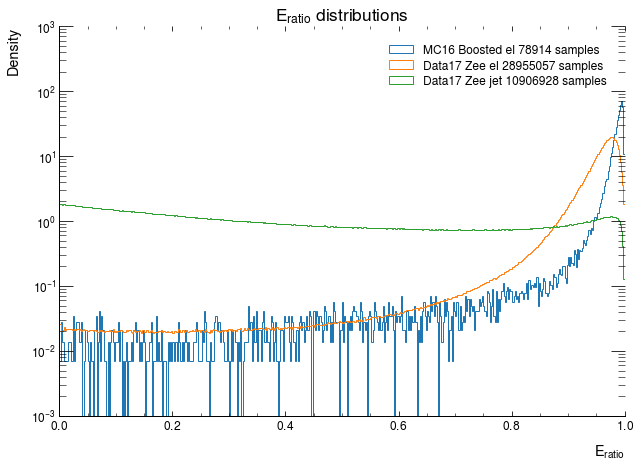

In [26]:
var='eratio'
var_info = get_var_info(var)
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
ax, hist, bins = histplot(data, var_info['l2calo'], xlabel=var_info['label'], xrange=(0,1), 
                          xbins=500, include_legend=True, xlim=None,
                          include_title=True, ax=ax, plot_scale='log', despine=True)
fig.tight_layout()

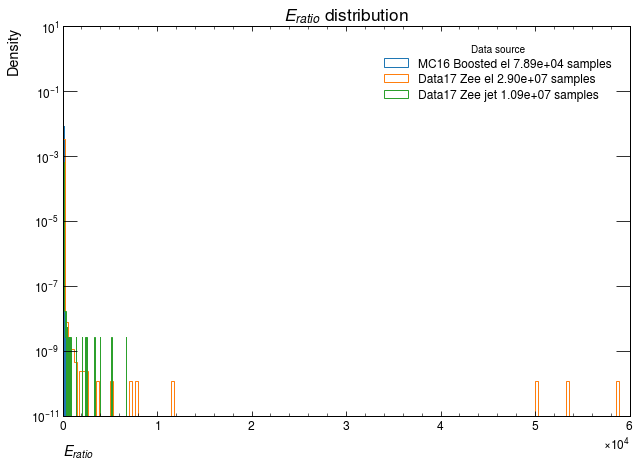

In [98]:
var='eratio'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=None, bins=200))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)

ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'], loc='left')
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')

# sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))

fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 20:47:01,075 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 20:47:01,151 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 20:47:01,216 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 20:47:01,277 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 20:47:01,349 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 20:47:01,403 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 20:47:01,530 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 20:47:01,633 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 20:47:01,699 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 20:47:01,807 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 20:47:01,867 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 20:47:02,178 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 20:47:02,357 - At bin 12 et_range [30.0, 40.

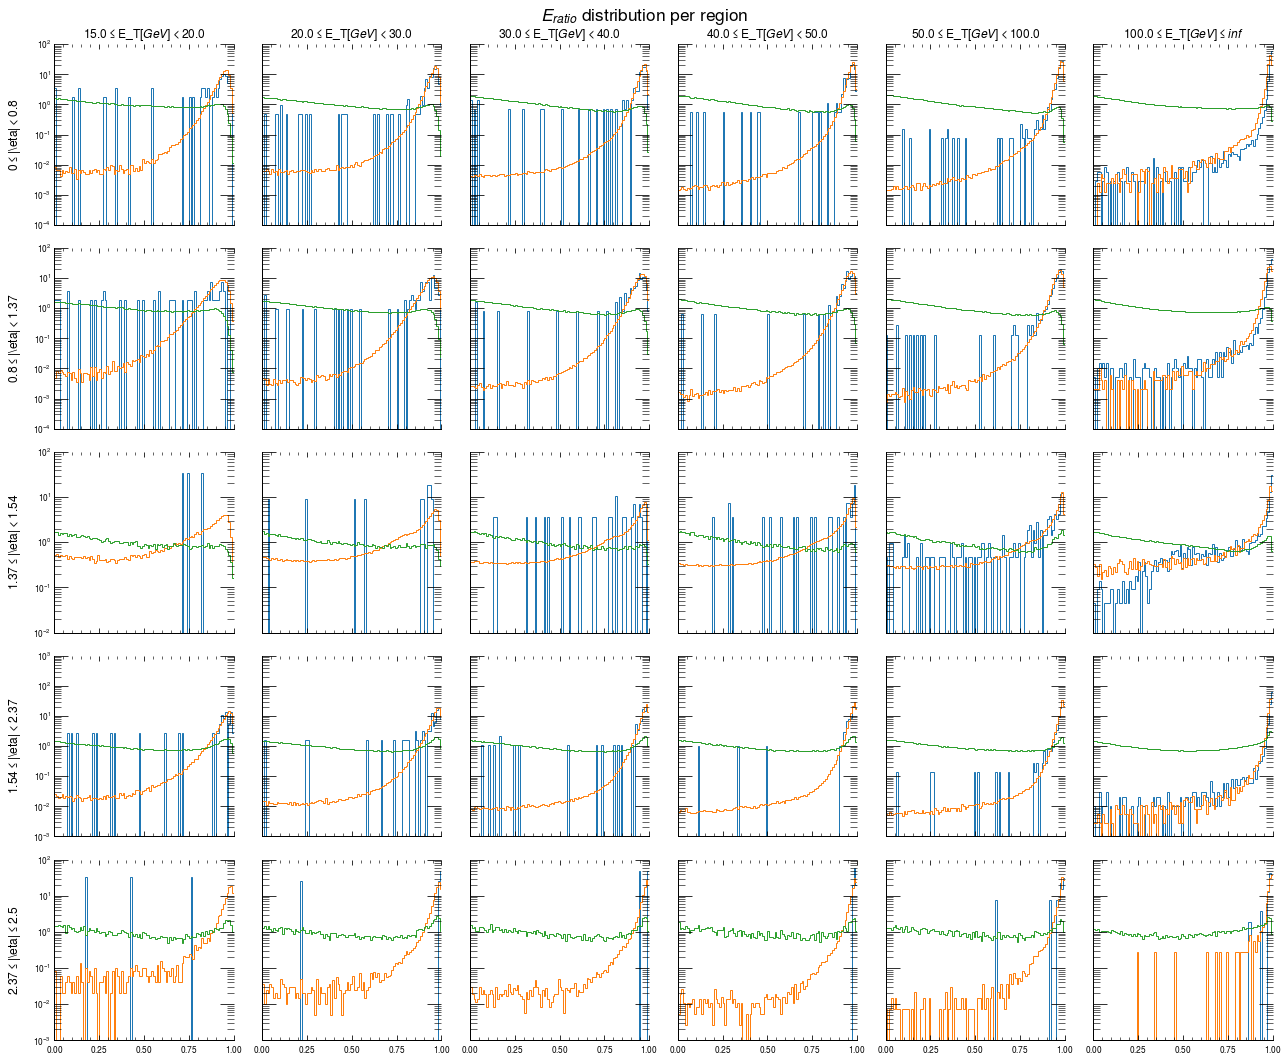

In [55]:
var='eratio'
plot_scale = 'log'
params = {
    'MC16 Boosted el':{
        'bins': 100,
        'range':(0,1)
    },
    'Data17 Zee el':{
        'bins': 100,
        'range':(0,1)
    },
    'Data17 Zee jet':{
        'bins': 100,
        'range':(0,1)
    }
}
row_lower_limits = [1e-4, 1e-4, 1e-2, 1e-3, 1e-3]
row_upper_limits = [1e2 for _ in range(len(row_lower_limits))]
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $R_{\eta}$
This shower shape is a ratio between Energy in 3x7 region by 7x7 region (The regions are $\eta$ x $\phi$). This way the shower shape should be limited to the [0,1] interval. However there were values bigger than 1 that were discarded.

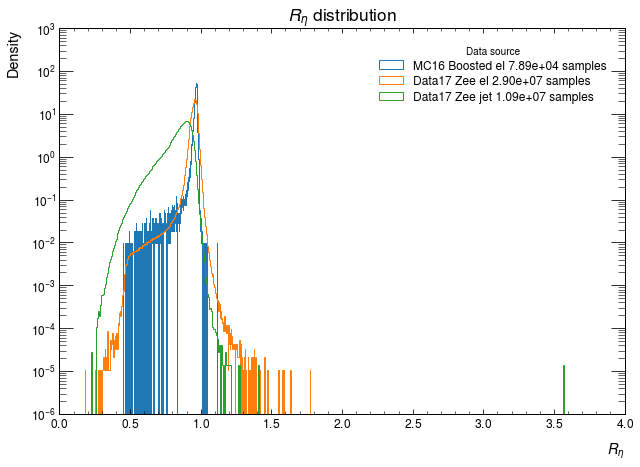

In [101]:
var='reta'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=None, bins=500))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)

ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'])
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')

# sub_ax_pos = [0.1, 0.6, 0.42, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))

fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 20:47:21,354 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 20:47:21,430 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 20:47:21,491 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 20:47:21,546 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 20:47:21,612 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 20:47:21,664 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 20:47:21,786 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 20:47:21,919 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 20:47:22,005 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 20:47:22,125 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 20:47:22,183 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 20:47:22,413 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 20:47:22,562 - At bin 12 et_range [30.0, 40.

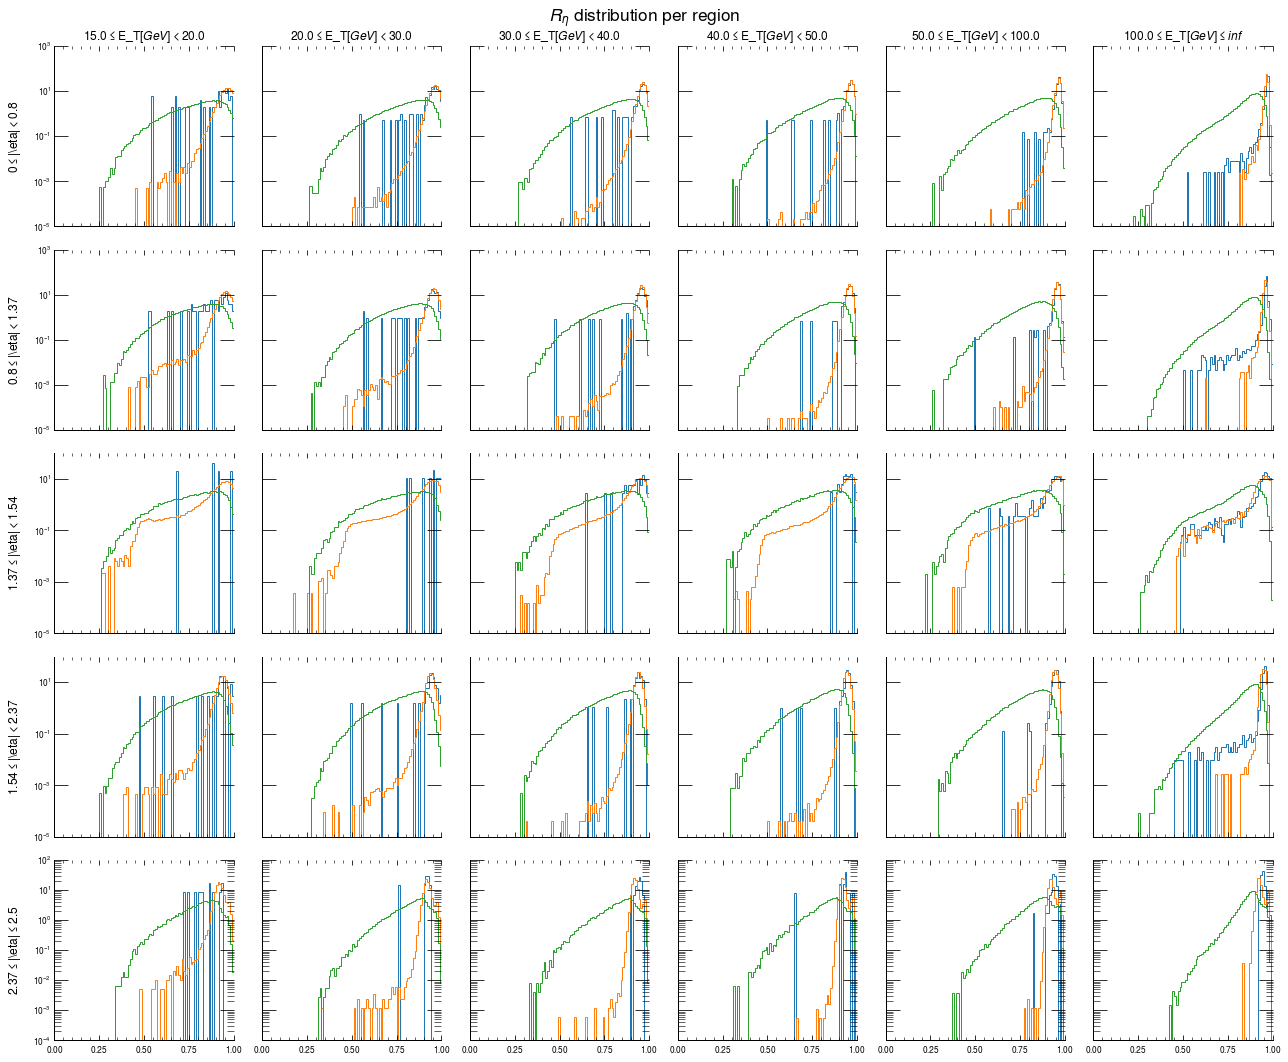

In [56]:
var='reta'
plot_scale = 'log'
params = {
    'MC16 Boosted el':{
        'bins': 100,
        'range':(0,1)
    },
    'Data17 Zee el':{
        'bins': 100,
        'range':(0,1)
    },
    'Data17 Zee jet':{
        'bins': 100,
        'range':(0,1)
    }
}
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $E_{had1}$
No documentation

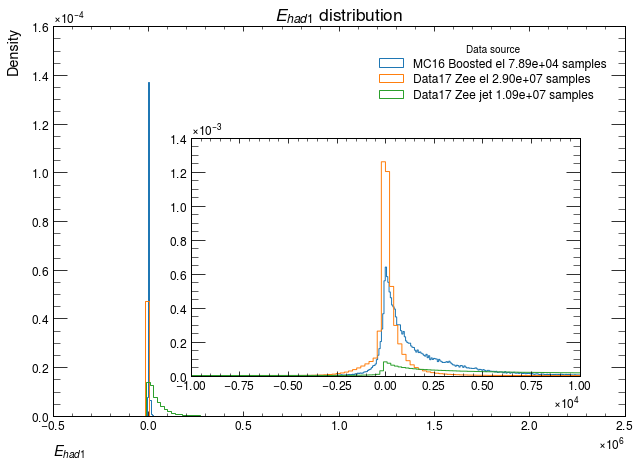

In [154]:
var='ehad1'
var_info = get_var_info(var)
plot_scale = 'linear'
kwargs = dict.fromkeys(data.keys(), dict(range=(None), bins=100))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'], loc='left')
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()
sub_ax_pos = [0.3, 0.2, 0.6, 0.5]
sub_ax = fig.add_axes(sub_ax_pos)
make_hist1d_plot(data, var, sub_ax, **dict.fromkeys(data.keys(), dict(range=(None), bins=10000)))
sub_ax.set(xlim=(-0.1e5, 0.1e5), yscale=plot_scale)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 20:53:20,802 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 20:53:20,883 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 20:53:20,942 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 20:53:20,993 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 20:53:21,055 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 20:53:21,103 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 20:53:21,222 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 20:53:21,310 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 20:53:21,367 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 20:53:21,462 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 20:53:21,519 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 20:53:21,797 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 20:53:21,946 - At bin 12 et_range [30.0, 40.

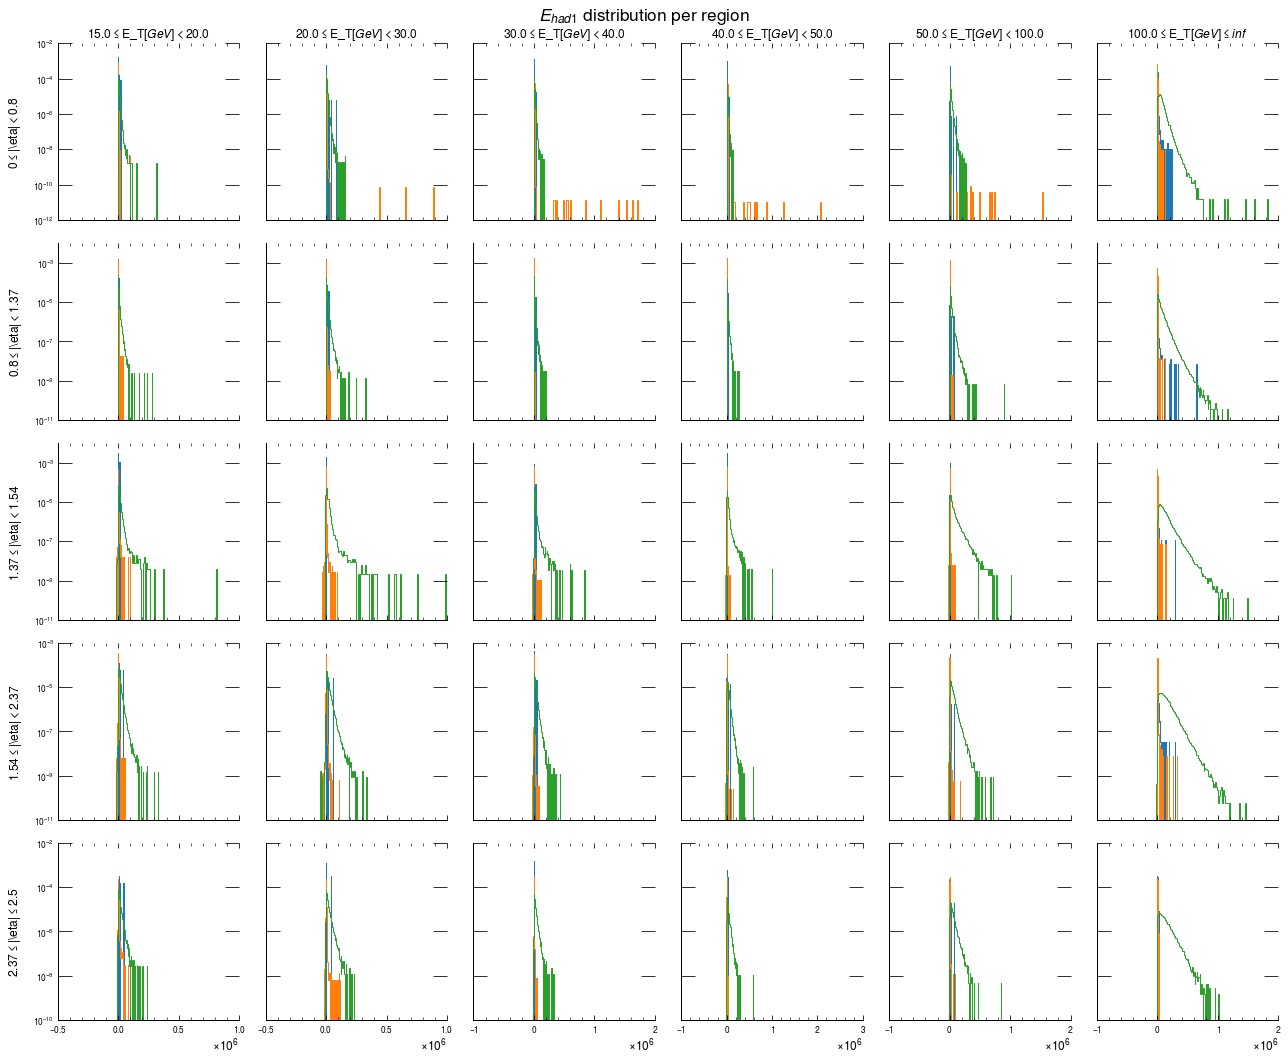

In [63]:
var='ehad1'
plot_scale = 'log'
params = {
    'MC16 Boosted el':{
        'bins': 100,
        'range':None
    },
    'Data17 Zee el':{
        'bins': 100,
        'range':None
    },
    'Data17 Zee jet':{
        'bins': 100,
        'range':None
    }
}
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $f_1$

This shower shape is a ratio between the energy deposited in EM1 over the total energy in the EM layers. This way the shower shape should be limited to the [0,1] interval. All values were in that interval.

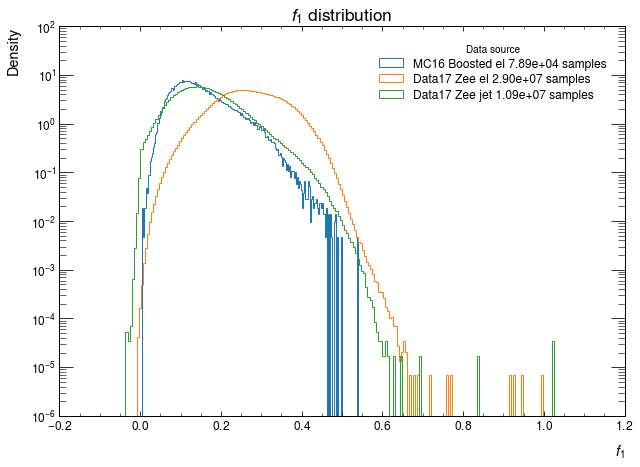

In [105]:
var='f1'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=(None), bins=200))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'])
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
# sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 21:00:31,299 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 21:00:31,382 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 21:00:31,448 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 21:00:31,519 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 21:00:31,588 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 21:00:31,642 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 21:00:31,776 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 21:00:31,869 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 21:00:31,936 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 21:00:32,043 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 21:00:32,098 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 21:00:32,358 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 21:00:32,510 - At bin 12 et_range [30.0, 40.

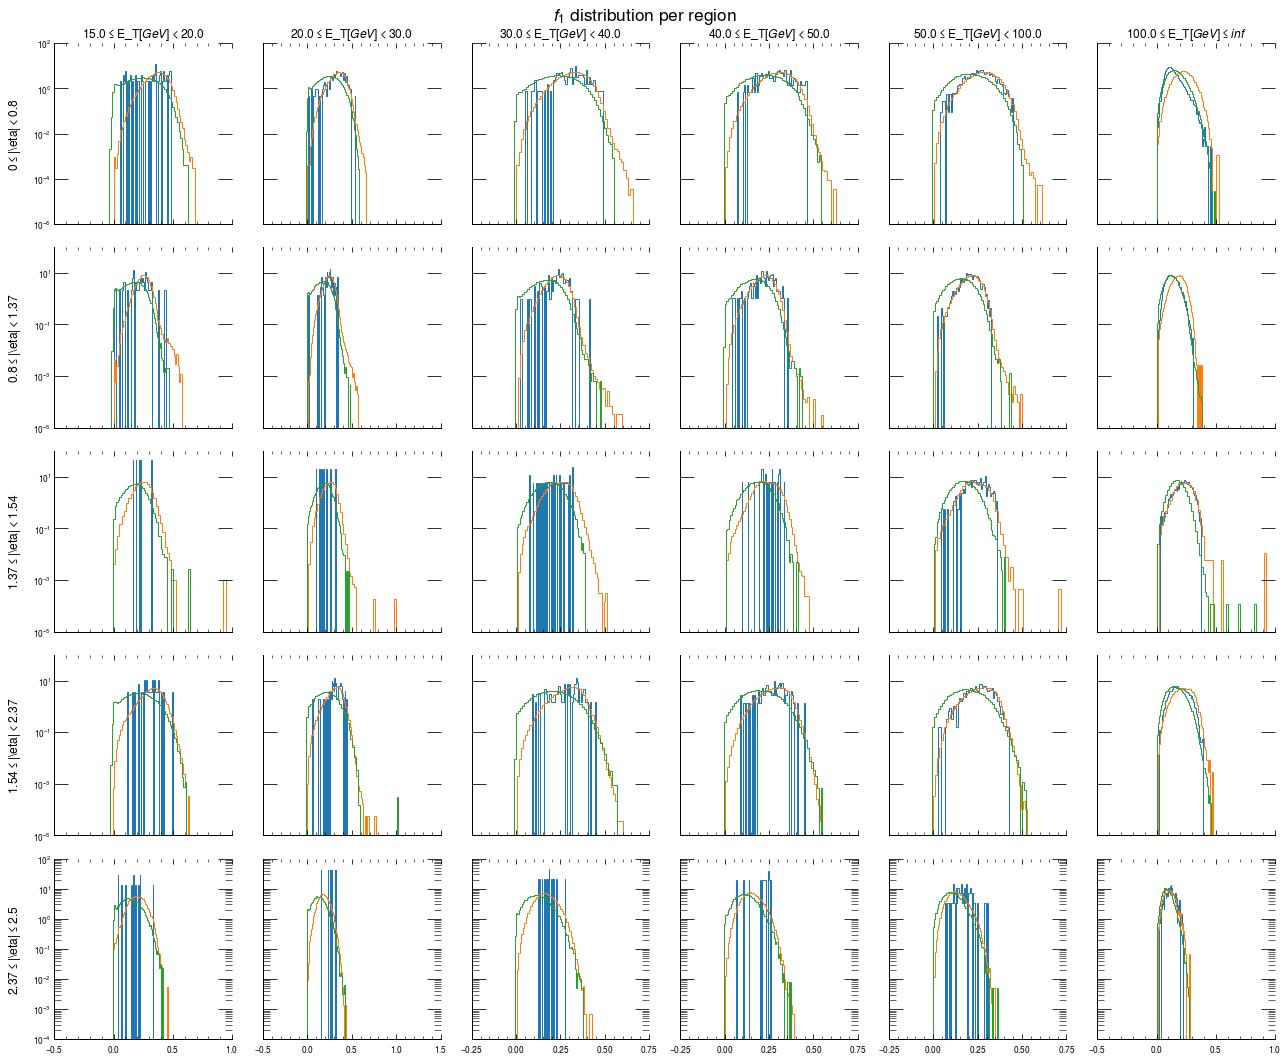

In [73]:
var='f1'
plot_scale = 'log'
params = dict.fromkeys(data.keys(), dict(range=(None), bins=50))
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $f_3$

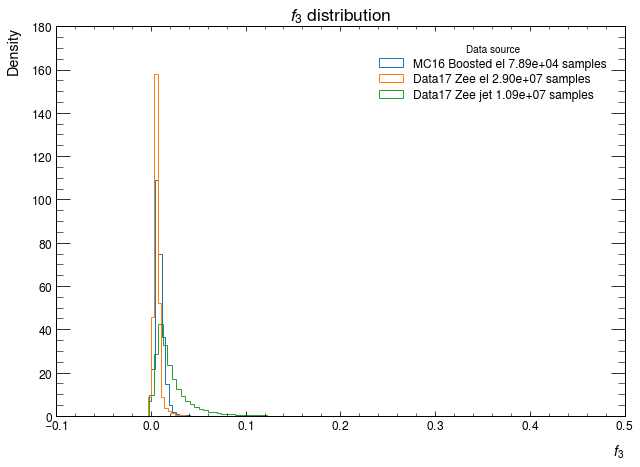

In [107]:
var='f3'
var_info = get_var_info(var)
plot_scale = 'linear'
kwargs = dict.fromkeys(data.keys(), dict(range=(None), bins=100))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'])
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
# sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 21:09:52,615 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 21:09:52,719 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 21:09:52,778 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 21:09:52,832 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 21:09:52,897 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 21:09:52,950 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 21:09:53,074 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 21:09:53,164 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 21:09:53,226 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 21:09:53,328 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 21:09:53,384 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 21:09:53,619 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 21:09:53,776 - At bin 12 et_range [30.0, 40.

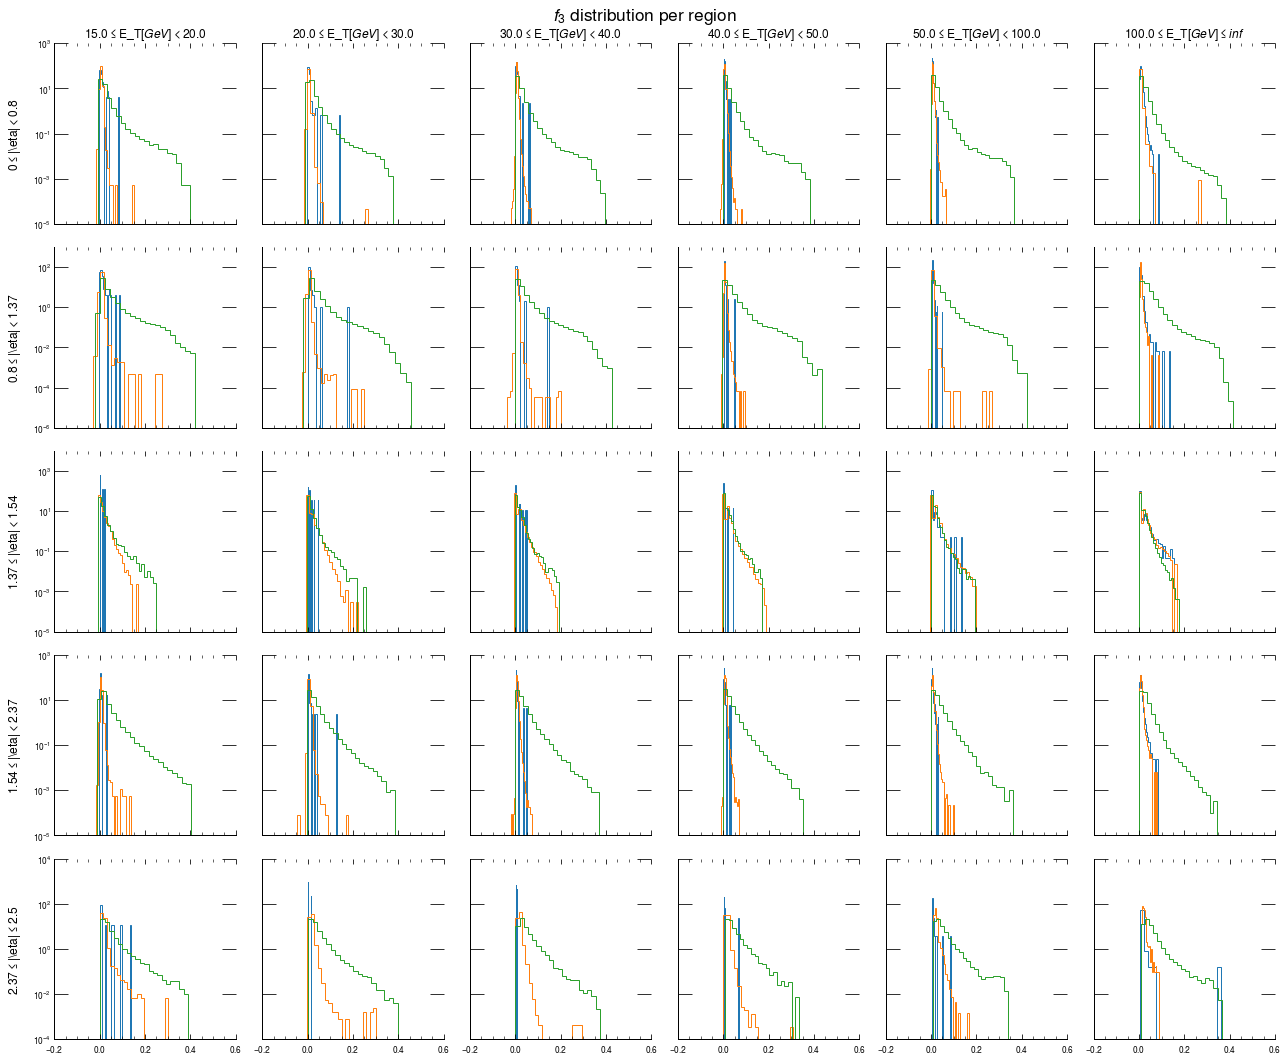

In [78]:
var='f3'
plot_scale = 'log'
params = dict.fromkeys(data.keys(), dict(range=(None), bins=20))
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $\omega_{\eta 2}$
Radial variance of energy deposition in a 3x5 region of EM2 centered in the hottest cell.
Can have multiple values but two modes were identified with the free axis:
- [0, 0.06]: The distributions had different formats
- [98.999, 99]: There was a little number of samples and mostly all of them were 99. As a result of these factors the data between this interval was discarded.

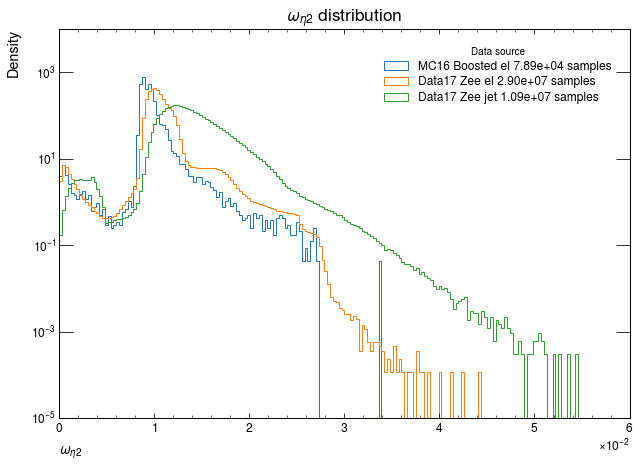

In [110]:
var='weta2'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=(0,0.06), bins=200))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'], loc='left')
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
# sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 21:14:08,639 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 21:14:08,752 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 21:14:08,822 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 21:14:08,877 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 21:14:08,941 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 21:14:08,996 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 21:14:09,135 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 21:14:09,234 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 21:14:09,301 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 21:14:09,408 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 21:14:09,470 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 21:14:09,725 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 21:14:09,882 - At bin 12 et_range [30.0, 40.

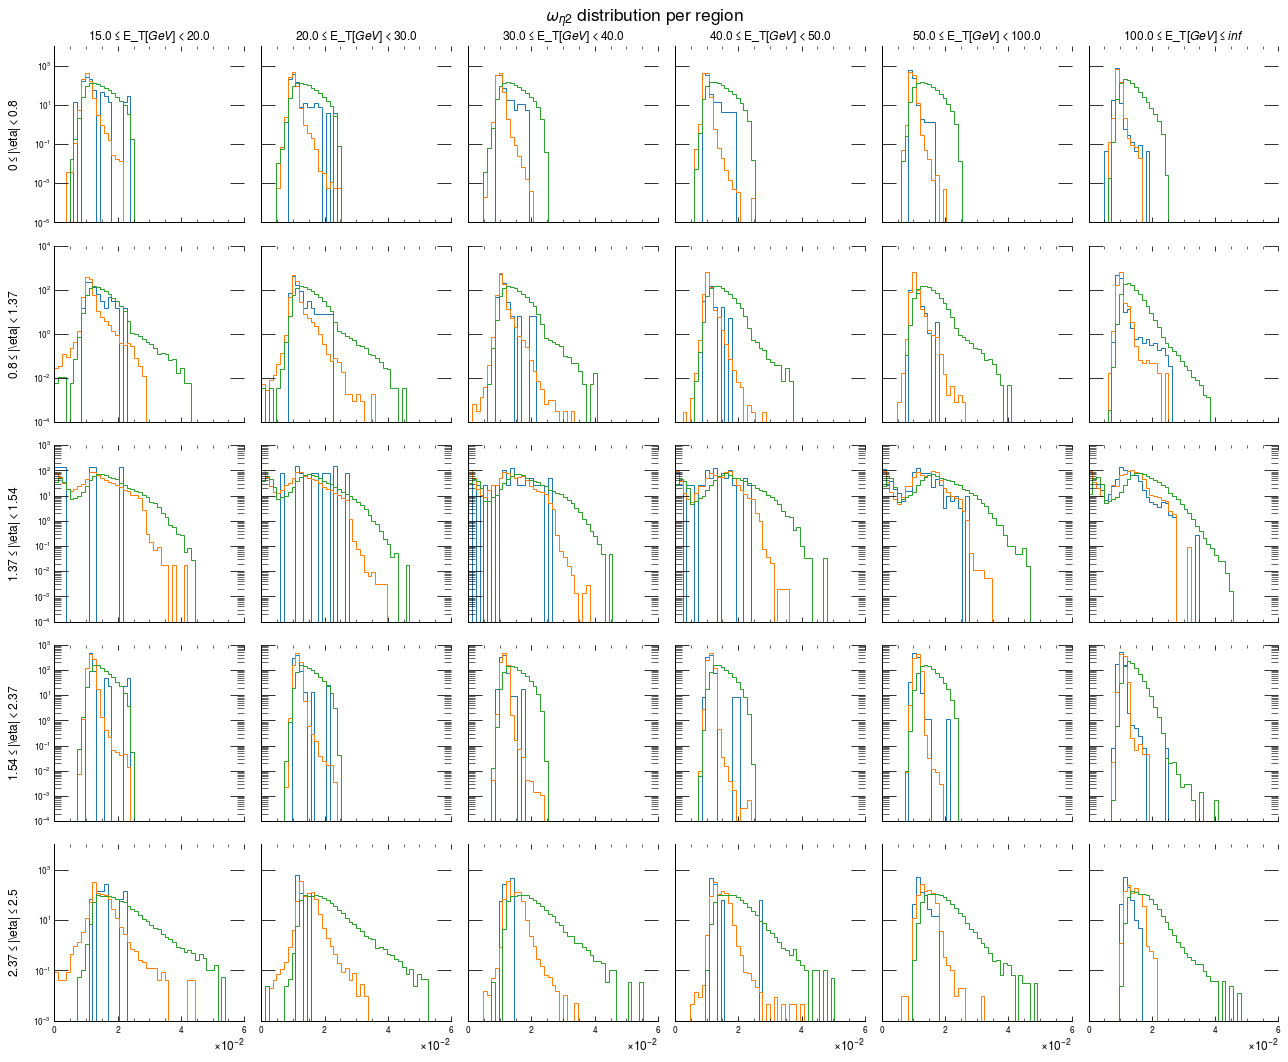

In [83]:
var='weta2'
plot_scale = 'log'
params = dict.fromkeys(data.keys(), dict(range=(0,0.06), bins=50))
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $w_{stot}$

This shower shape is a root over a squared error, therefore, it cannot be negative. WHen building the histogram with a free range 3 modes were identified:
- -9999: Some samples had this value and were discarded
- [0, 468]: Showed excepted behavior

/tmp/ipykernel_1070/251316372.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


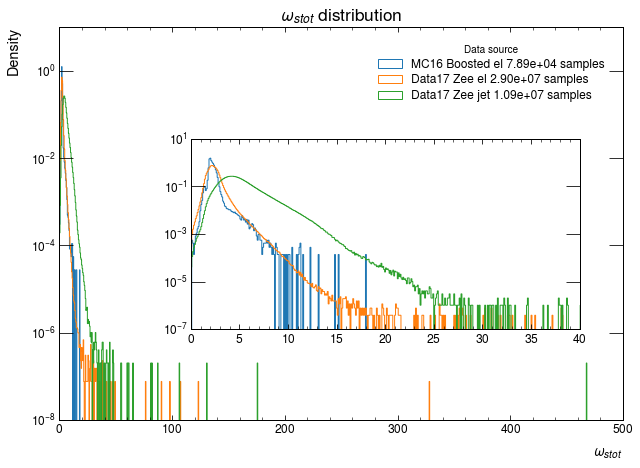

In [124]:
var='wstot'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=(0,468), bins=1000))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'])
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
sub_ax_pos = [0.3, 0.3, 0.6, 0.4]
sub_ax = fig.add_axes(sub_ax_pos)
make_hist1d_plot(data, var, sub_ax, **dict.fromkeys(data.keys(), dict(range=(0,468), bins=5000)))
sub_ax.set(xlim=(0,40), yscale=plot_scale)
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 21:18:41,898 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 21:18:41,980 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 21:18:42,042 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 21:18:42,097 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 21:18:42,163 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 21:18:42,216 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 21:18:42,344 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 21:18:42,441 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 21:18:42,507 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 21:18:42,616 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 21:18:42,681 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 21:18:42,965 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 21:18:43,171 - At bin 12 et_range [30.0, 40.

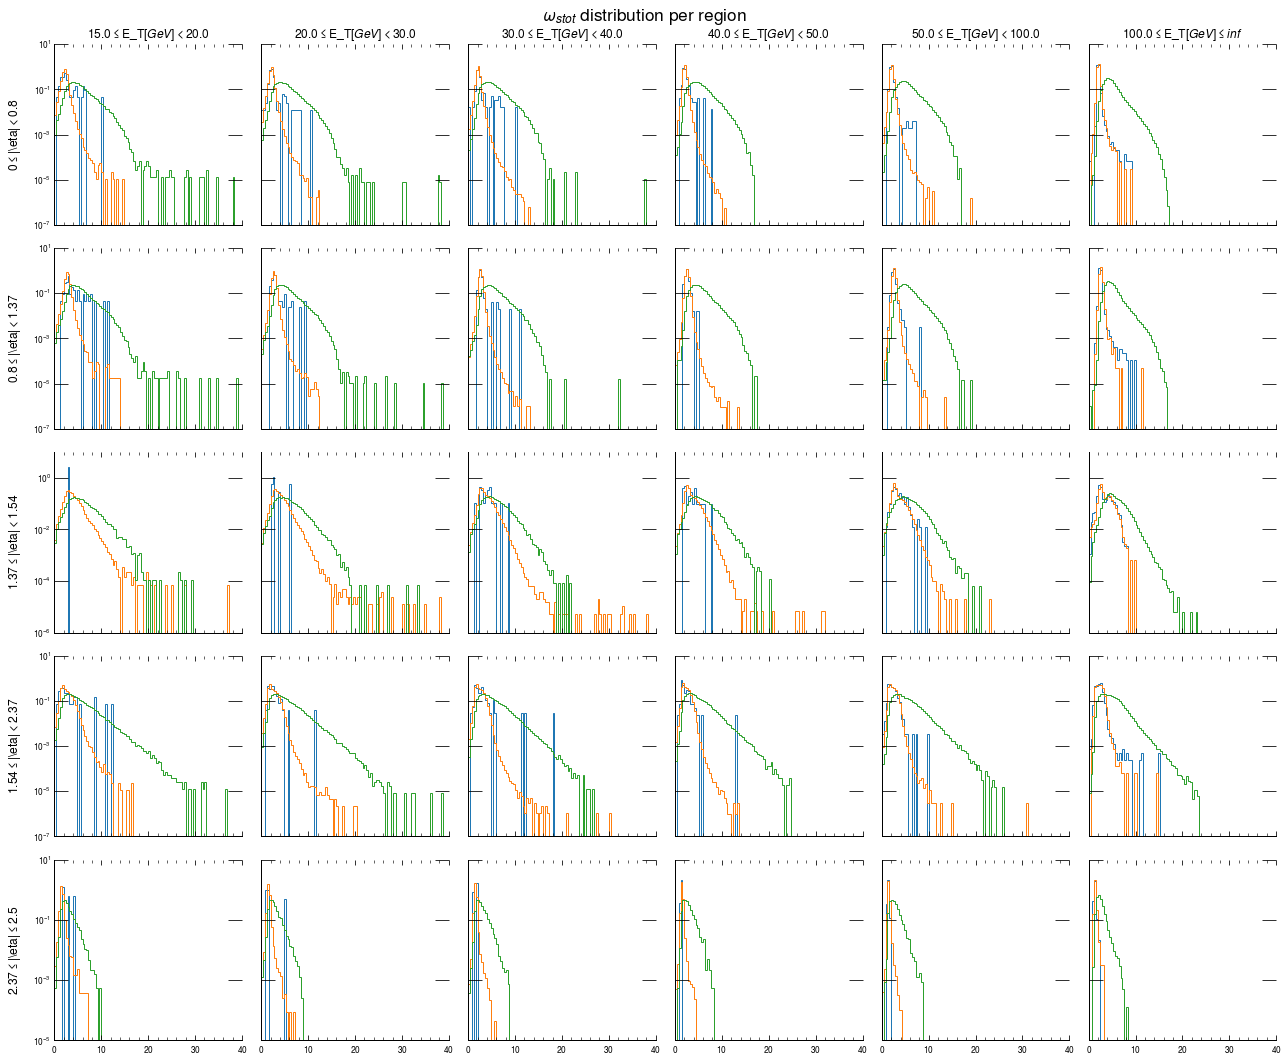

In [95]:
var='wstot'
plot_scale = 'log'
params = dict.fromkeys(data.keys(), dict(range=(0,40), bins=100))
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### e2tsts1
For this shower shape there is a peak of negative values between [-999,0]. The name of the col starts with e which may indicate that this value is related to energy. Could not find on my articles what it means.

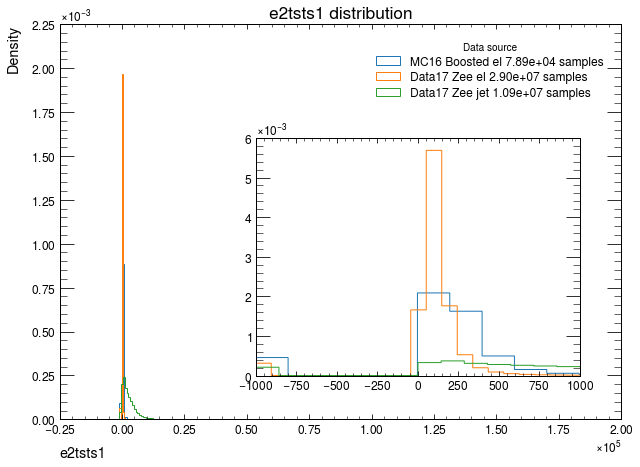

In [137]:
var='e2tsts1'
var_info = get_var_info(var)
plot_scale = 'linear'
kwargs = dict.fromkeys(data.keys(), dict(range=None, bins=200))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)

ax.legend(title='Data source')
ax.set_xlabel(var_info['label'], loc='left')
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()

sub_ax_pos = [0.4, 0.2, 0.5, 0.5]
sub_ax = fig.add_axes(sub_ax_pos)
make_hist1d_plot(data, var, sub_ax, **dict.fromkeys(data.keys(), dict(range=None, bins=1000)))
sub_ax.set(xlim=(-0.1e4, 0.1e4), yscale=plot_scale)

fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

In [131]:
for key in data_hists.keys():
    data_hists[key] = get_hist_df(*data_hists[key])
save_hists_df(data_hists, output_dir, var, 'free_range')

0

### $E_t$

0

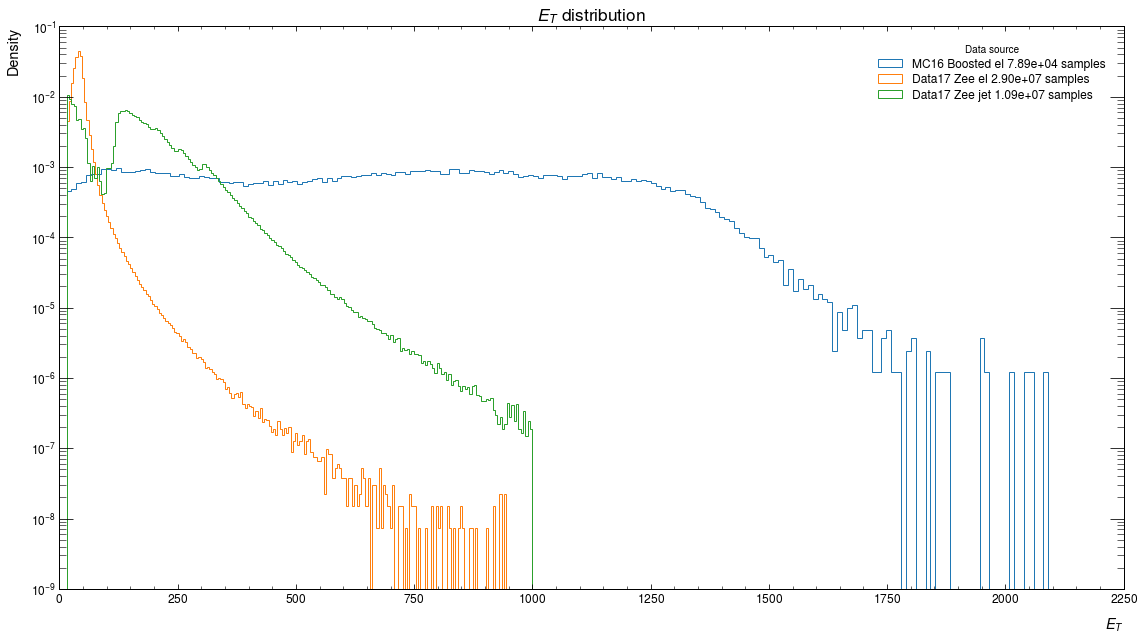

In [96]:
var='et'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=(None), bins=200))
fig, ax = plt.subplots(1,1, figsize=(16,9), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'])
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
# sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
for key in data_hists.keys():
    data_hists[key] = get_hist_df(*data_hists[key])
save_hists_df(data_hists, output_dir, var, 'free_range')

## Joint Plots

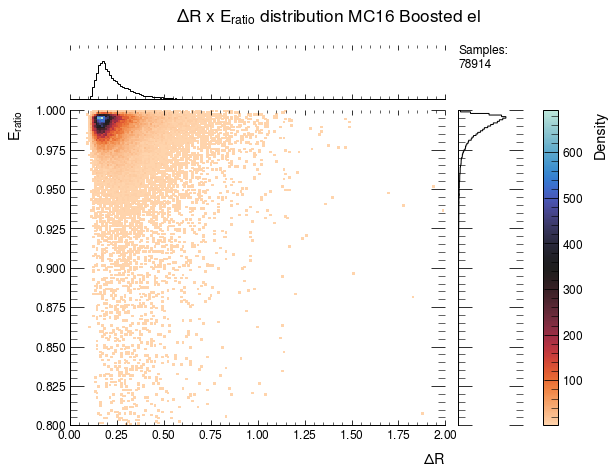

In [99]:
data_name = 'MC16 Boosted el'
x='dr'
y='eratio'
x_info = get_var_info(x)
y_info = get_var_info(y)
jgrid, _ = jointplot(data=data[data_name], x=x_info['TaP'], y=y_info['l2calo'], 
                      x_label=x_info['label'], y_label=y_info['label'], data_label=data_name,
                      x_bins=500, y_bins=1000, x_range=None, y_range=(0,1), xlim=(0,2), ylim=(0.8,1),
                      cmap='icefire_r', plot_scale='linear', figsize=(9,6.6), marginal_ticks=False)
jgrid.figure.savefig()

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


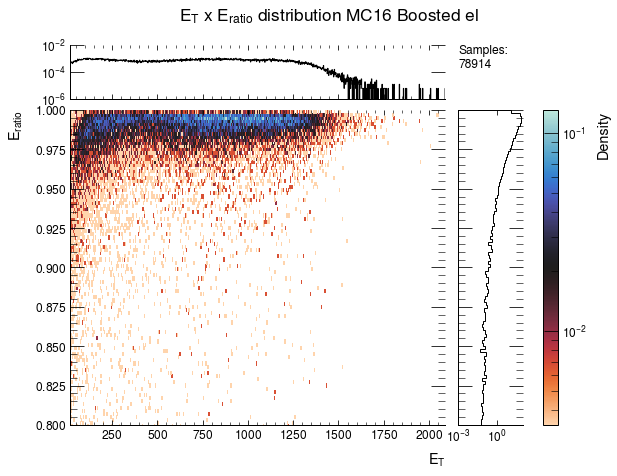

In [95]:
data_name = 'MC16 Boosted el'
x='et'
y='eratio'
x_info = get_var_info(x)
y_info = get_var_info(y)
jgrid, return_dict = jointplot(data=data[data_name], x=x_info['l2calo'], y=y_info['l2calo'], 
                          x_label=x_info['label'], y_label=y_info['label'], data_label=data_name,
                          x_bins=1000, y_bins=500, x_range=None, y_range=(0,1), xlim=None, ylim=(0.8,1),
                          cmap='icefire_r', plot_scale='log', figsize=(9,6.6))

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


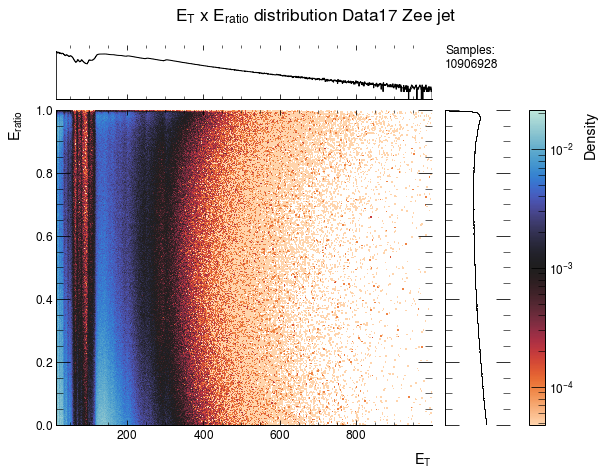

In [97]:
data_name = 'Data17 Zee jet'
x='et'
y='eratio'
x_info = get_var_info(x)
y_info = get_var_info(y)
jgrid, return_dict = jointplot(data=data[data_name], x=x_info['l2calo'], y=y_info['l2calo'], 
                          x_label=x_info['label'], y_label=y_info['label'], data_label=data_name,
                          x_bins=1000, y_bins=500, x_range=None, y_range=(0,1), xlim=None, ylim=None,
                          cmap='icefire_r', plot_scale='log', figsize=(9,6.6), marginal_ticks=False)

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


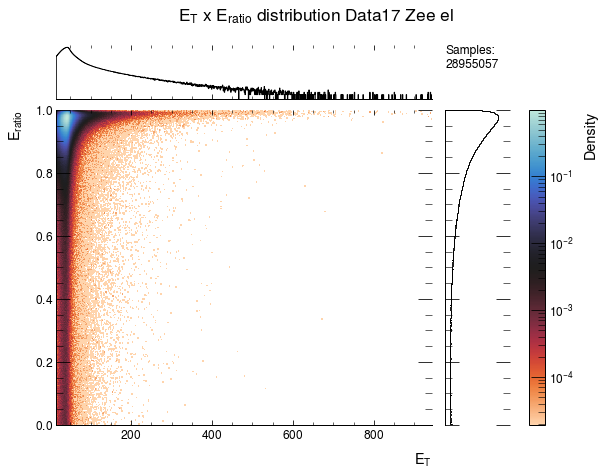

In [98]:
data_name = 'Data17 Zee el'
x='et'
y='eratio'
x_info = get_var_info(x)
y_info = get_var_info(y)
jgrid, return_dict = jointplot(data=data[data_name], x=x_info['l2calo'], y=y_info['l2calo'], 
                          x_label=x_info['label'], y_label=y_info['label'], data_label=data_name,
                          x_bins=1000, y_bins=500, x_range=None, y_range=(0,1), xlim=None, ylim=None,
                          cmap='icefire_r', plot_scale='log', figsize=(9,6.6), marginal_ticks=False)

## End

In [56]:
plt.close('all')